# Pneumonia Image Classification

This project uses Chest X-Ray images labeled with different types of Pneumonia to train a deep learning model using the [InceptionV3](https://cloud.google.com/tpu/docs/inception-v3-advanced) [Convolutional Neural Network (CNN)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) as a starting point for [transfer learning](https://www.youtube.com/watch?v=yofjFQddwHE) to train our final model which will ultimately be able to classify X-Ray images into Pneumonia predictions.

The dataset for this project comes from the [Kaggle Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). Please download the zip file and drop the zip file into the /Data directory in this repository to get started.

## Setup

In [ ]:
# This command is for MacOSX terminal
!unzip Data/chest-xray-pneumonia.zip -d temp/
# Unzip the 2nd zip file inside the first and delete __MACOSX folder inside zip file
!zip -d temp/chest_xray.zip "__MACOSX*"
!unzip temp/chest_xray.zip -d temp/
# Change file permissions to ensure files are readable
!chmod 777 temp/*.*

In [ ]:
# Make sure we have all the required modules imported into our environment

import sys
!{sys.executable} -m pip install -U pandas
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U image
!{sys.executable} -m pip install -U keras
!{sys.executable} -m pip install -U tensorflow

## Loading The Datasets

The images are organised under the temp/chest_xray folder in `train`, `test` & `val` folders. Under each of those folders are two more folders: `NORMAL` and `PNEUMONIA`. Bacterial pneumonia and Viral pneumonia can be differentiated by the filename (`bacteria` or `virus` in the filename respectively)

To allow us to train the model to predict between different types of pneumonia, we will load the list of images with their categories into dataframes.

One issue we can see is that the validation dataset has no examples of Viral pneumonia for training. This will cause our validation step during training to fail as our dataset class size is smaller so we will fix this by copying some of the virus x-rays to the validation folder.

In [32]:
# Setup the directory paths
input_directory = r"temp/chest_xray/"
training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"

import pandas as pd
import os

def load_img_dataframe(path):
    """
    Loads all image paths with their category under root directory into a Pandas dataframe
    """
    
    dataframe = pd.DataFrame(columns=['img', 'label'])
    
    # Load NORMAL images first
    normal_imgs = os.listdir(path + '/NORMAL')
    for image in normal_imgs:
        if '.jpeg' in image:
            dataframe = dataframe.append({'img' : os.path.abspath(path + '/NORMAL/' + image), 'label' : 'NORMAL'}, 
                                         ignore_index=True)
    
    # Load PNEUMONIA images next, labeling between Bacterial and Viral Pneumonia
    pneumonia_imgs = os.listdir(path + '/PNEUMONIA')
    for image in pneumonia_imgs:
        if '.jpeg' in image:
            if 'bacteria' in image:
                dataframe = dataframe.append({'img' : os.path.abspath(path + '/PNEUMONIA/' + image), 'label' : 'BACTERIAL'}, 
                                             ignore_index=True)
            if 'virus' in image:
                dataframe = dataframe.append({'img' : os.path.abspath(path + '/PNEUMONIA/' + image), 'label' : 'VIRAL'}, 
                                             ignore_index=True)
        
    return dataframe

# Move 8 viral pneumonia x-rays to the validation directory
pneumonia_imgs = os.listdir(training_dir + '/PNEUMONIA')
i = 0
for image in pneumonia_imgs:
    if i >= 8:
        break
    else:
        if '.jpeg' in image:
            if 'virus' in image:
                os.rename(os.path.abspath(training_dir + '/PNEUMONIA/' + image), 
                          os.path.abspath(validation_dir + '/PNEUMONIA/' + image))
                i += 1 

# Load datasets
df_train = load_img_dataframe(training_dir)
df_val = load_img_dataframe(validation_dir)
df_test = load_img_dataframe(testing_dir)

# Show the head of the df_train dataset to validate it looks OK
print(df_train.iloc[0]['img'])
df_train.head()

/Users/dgildeh/Development/ML-Course/jupyter-notebooks/temp/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg


,img,label
0,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
1,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
2,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
3,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL
4,/Users/dgildeh/Development/ML-Course/jupyter-n...,NORMAL


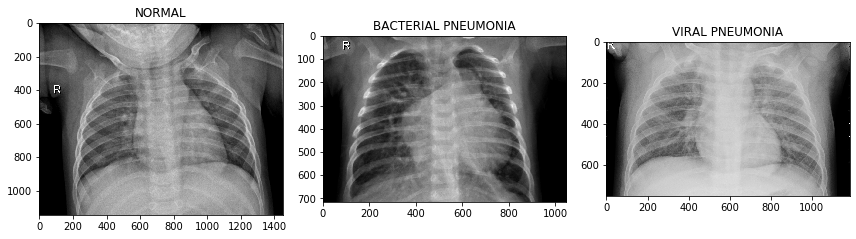

In [33]:
# Show some sample images from the training dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img_normal = plt.imread(f'{training_dir}/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread(f'{training_dir}/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread(f'{training_dir}/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('BACTERIAL PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('VIRAL PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

Total Training Images: 5208
Total Validation Images: 24
Total Testing Images: 624


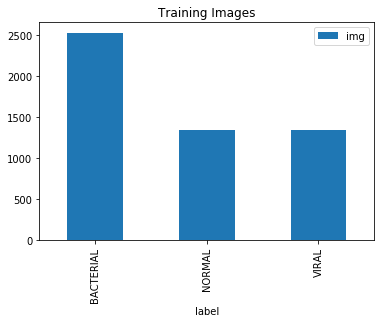

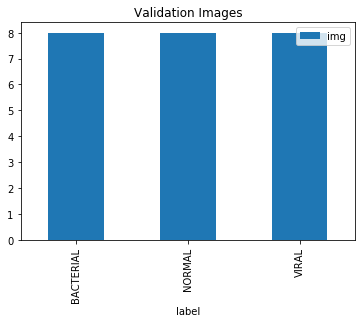

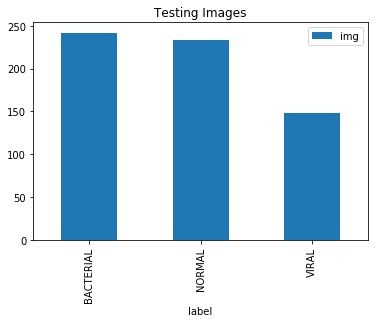

In [34]:
# Plot how many of each category we have in each dataset
def plot_img_count(df, title):
    pivot_df = pd.pivot_table(df, index='label', values='img', aggfunc='count').plot.bar(stacked=True,
                                                                                         title=title)
    print(f"Total {title}: {len(df)}")

plot_img_count(df_train, 'Training Images')
plot_img_count(df_val, 'Validation Images')
plot_img_count(df_test, 'Testing Images')

## Setup & Train Model

1. Setup the image pipeline so we can pass batches of images to the model for training
2. Load the InceptionV3 model without the top layer. This way we get transfer learning from all the other neural network layers which have been trained to recognise images on 1mil's of images (such as shapes, lines and other common image features) and replace the top categorisation layer with our own to predict the 3 labels we are training for: NORMAL, VIRAL & BACTERIAL
3. Train the model against the df_train dataset
4. Test the model using the df_test dataset

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup Image Processig Pipelines for each dataset
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='img',
    y_col='label',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_dataframe(
    df_val,
    x_col='img',
    y_col='label',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=len(df_val),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='img',
    y_col='label',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=len(df_test),
    shuffle = False)

Found 5208 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

K.clear_session()

# Load the InceptionV3 model and replace the top layer with our own layers for training
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Make sure we don't change the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# We have 3 classes we want to predict: NORMAL, BACTERIAL, VIRAL
NUM_CLASSES = 3

# Add our own 3 category classifer to the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [37]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate training class weights
y = train_generator.classes
labels = np.unique(y)
train_class_weights = compute_class_weight('balanced', labels, y)

# Train and save the model to the local 'models' directory
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'models/pneumonia_v0.1.hd5'
model.save(MODEL_FILE)

Epoch 1/100
32/32 [==============================] - 111s 3s/step - loss: 1.3637 - acc: 0.3529 - val_loss: 1.6192 - val_acc: 0.2500
Epoch 2/100
32/32 [==============================] - 99s 3s/step - loss: 1.2069 - acc: 0.4334 - val_loss: 1.5646 - val_acc: 0.2500
Epoch 3/100
32/32 [==============================] - 101s 3s/step - loss: 1.1380 - acc: 0.4535 - val_loss: 1.5918 - val_acc: 0.5000
Epoch 4/100
32/32 [==============================] - 101s 3s/step - loss: 1.1030 - acc: 0.4760 - val_loss: 1.6437 - val_acc: 0.5000
Epoch 5/100
32/32 [==============================] - 101s 3s/step - loss: 1.0722 - acc: 0.4898 - val_loss: 1.5830 - val_acc: 0.5000
Epoch 6/100
32/32 [==============================] - 105s 3s/step - loss: 1.0263 - acc: 0.5269 - val_loss: 1.6972 - val_acc: 0.4583
Epoch 7/100
32/32 [==============================] - 680s 21s/step - loss: 0.9944 - acc: 0.5361 - val_loss: 1.7042 - val_acc: 0.4583
Epoch 8/100
32/32 [==============================] - 106s 3s/step - loss: 0.

32/32 [==============================] - 101s 3s/step - loss: 0.7143 - acc: 0.6868 - val_loss: 1.3884 - val_acc: 0.5833
Epoch 63/100
32/32 [==============================] - 101s 3s/step - loss: 0.7100 - acc: 0.6911 - val_loss: 1.3498 - val_acc: 0.5417
Epoch 64/100
32/32 [==============================] - 101s 3s/step - loss: 0.7065 - acc: 0.6914 - val_loss: 1.3577 - val_acc: 0.5833
Epoch 65/100
32/32 [==============================] - 102s 3s/step - loss: 0.7047 - acc: 0.6899 - val_loss: 1.3849 - val_acc: 0.5833
Epoch 66/100
32/32 [==============================] - 102s 3s/step - loss: 0.6988 - acc: 0.6955 - val_loss: 1.2790 - val_acc: 0.5417
Epoch 67/100
32/32 [==============================] - 101s 3s/step - loss: 0.7056 - acc: 0.6884 - val_loss: 1.3479 - val_acc: 0.5000
Epoch 68/100
32/32 [==============================] - 101s 3s/step - loss: 0.6979 - acc: 0.6945 - val_loss: 1.3533 - val_acc: 0.5833
Epoch 69/100
32/32 [==============================] - 102s 3s/step - loss: 0.7050 

OSError: Unable to create file (unable to open file: name = 'models/pneumonia_v0.1.hd5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)